# CNN Deforestation Detection Pipeline
**Patch-based 2D CNN with Spatial Context**

Du an: Giam sat Bien dong Rung tinh Ca Mau | SV: Ninh Hai Dang (21021411)

## Pipeline Overview
1. Setup & Libraries -> 2. Load Data -> 3. Feature Extraction -> 4. Spatial Split -> 5. Extract Patches -> 6. Train CNN -> 7. Evaluate -> 8. Predict -> 9. Visualize -> 10. Summary

## 1️⃣ Setup & Import Libraries

In [1]:
import sys
from pathlib import Path

# Add src to path
project_root = Path.cwd().parent
sys.path.insert(0, str(project_root / 'src'))

# Core libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import json
import time
import warnings
warnings.filterwarnings('ignore')

# PyTorch
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

# Geospatial
import rasterio
from rasterio.plot import show

# Sklearn
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, roc_auc_score,
    confusion_matrix, roc_curve, classification_report
)

# Check PyTorch and CUDA
print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"CUDA device: {torch.cuda.get_device_name(0)}")
    device = 'cuda'
else:
    print("Using CPU")
    device = 'cpu'

# Set random seeds for reproducibility
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)
torch.manual_seed(RANDOM_STATE)
if torch.cuda.is_available():
    torch.cuda.manual_seed(RANDOM_STATE)

print("\n✓ Libraries imported successfully!")

PyTorch version: 2.5.1+cu121
CUDA available: True
CUDA device: NVIDIA GeForce GTX 1060 6GB

✓ Libraries imported successfully!


### Configuration

In [2]:
# Configuration
CONFIG = {
    # Model
    'patch_size': 3,
    'n_features': 27,
    'n_classes': 4,  # ✅ Updated to 4 classes
    'dropout_rate': 0.7,  # Increased to prevent overfitting
    
    # Training
    'epochs': 100,  # Reduced from 500, model converges fast
    'batch_size': 64,  # Increased from 32
    'learning_rate': 0.001,
    'weight_decay': 1e-3,  # Increased to prevent overfitting
    'early_stopping_patience': 15,  # Reduced from 50 for faster stopping
    

    # Learning Rate Scheduler (for long training)
    'use_lr_scheduler': True,
    'lr_scheduler_type': 'ReduceLROnPlateau',
    'lr_scheduler_patience': 10,  # Reduced from 15
    'lr_scheduler_factor': 0.5,
    'lr_min': 1e-6,
        # Spatial split
    'cluster_distance': 50.0,
    'train_size': 0.70,
    'val_size': 0.15,
    'test_size': 0.15,
    
    # Device
    'device': device,
    
    # Prediction
    'pred_batch_size': 8000,
    'pred_stride': 1,
}

print("Configuration:")
for key, value in CONFIG.items():
    print(f"  {key:25s}: {value}")


Configuration:
  patch_size               : 3
  n_features               : 27
  n_classes                : 4
  dropout_rate             : 0.7
  epochs                   : 100
  batch_size               : 64
  learning_rate            : 0.001
  weight_decay             : 0.001
  early_stopping_patience  : 15
  use_lr_scheduler         : True
  lr_scheduler_type        : ReduceLROnPlateau
  lr_scheduler_patience    : 10
  lr_scheduler_factor      : 0.5
  lr_min                   : 1e-06
  cluster_distance         : 50.0
  train_size               : 0.7
  val_size                 : 0.15
  test_size                : 0.15
  device                   : cuda
  pred_batch_size          : 8000
  pred_stride              : 1


## 2️⃣ Load Data

In [3]:
from core.data_loader import DataLoader

print("Loading data...")
loader = DataLoader()

# Load all data
s2_before, s2_after = loader.load_sentinel2()
s1_before, s1_after = loader.load_sentinel1()
ground_truth = loader.load_ground_truth()
boundary = loader.load_boundary()

# Store metadata
metadata = loader.metadata

print("\n✓ Data loaded successfully!")
print(f"\nGround truth points: {len(ground_truth)}")
print(f"Class distribution:")
print(ground_truth['label'].value_counts())


2025-11-18 14:58:42 - core.data_loader - INFO - 
2025-11-18 14:58:42 - core.data_loader - INFO - LOADING SENTINEL-2 DATA (OPTICAL)
2025-11-18 14:58:42 - core.data_loader - INFO - ======================================================================
2025-11-18 14:58:42 - core.data_loader - INFO - Loading Sentinel-2 Before (2024-01-30): d:\ninhhaidang\25-26_HKI_DATN_21021411_DangNH\data\raw\sentinel-2\S2_2024_01_30.tif


Loading data...


2025-11-18 14:58:47 - core.data_loader - INFO -   [OK] Shape: (7, 10917, 12547)
2025-11-18 14:58:47 - core.data_loader - INFO -   [OK] Bands: 7
2025-11-18 14:58:47 - core.data_loader - INFO -   [OK] CRS: EPSG:32648
2025-11-18 14:58:47 - core.data_loader - INFO -   [OK] NoData: 0.0
2025-11-18 14:58:59 - core.data_loader - INFO - Loading Sentinel-2 After (2025-02-28): d:\ninhhaidang\25-26_HKI_DATN_21021411_DangNH\data\raw\sentinel-2\S2_2025_02_28.tif
2025-11-18 14:59:04 - core.data_loader - INFO -   [OK] Shape: (7, 10917, 12547)
2025-11-18 14:59:04 - core.data_loader - INFO -   [OK] Bands: 7
2025-11-18 14:59:04 - core.data_loader - INFO -   [OK] CRS: EPSG:32648
2025-11-18 14:59:04 - core.data_loader - INFO -   [OK] NoData: 0.0
2025-11-18 14:59:16 - core.data_loader - INFO - 
[OK] Sentinel-2 data loaded successfully
2025-11-18 14:59:16 - core.data_loader - INFO -   - Expected bands: ['B4', 'B8', 'B11', 'B12', 'NDVI', 'NBR', 'NDMI']
2025-11-18 14:59:16 - core.data_loader - INFO - 
2025-11-


✓ Data loaded successfully!

Ground truth points: 2630
Class distribution:
label
2    664
3    660
0    656
1    650
Name: count, dtype: int64


## 3️⃣ Feature Extraction

In [4]:
from core.feature_extraction import FeatureExtraction

print("Extracting features...")
extractor = FeatureExtraction()

feature_stack, valid_mask = extractor.extract_features(
    s2_before, s2_after,
    s1_before, s1_after
)

print(f"\n✓ Feature extraction completed!")
print(f"Feature stack shape: {feature_stack.shape}")
print(f"Valid pixels: {valid_mask.sum():,} / {valid_mask.size:,} ({valid_mask.sum()/valid_mask.size*100:.2f}%)")


2025-11-18 14:59:24 - core.feature_extraction - INFO - 
2025-11-18 14:59:24 - core.feature_extraction - INFO - STEP 3: FEATURE EXTRACTION
2025-11-18 14:59:24 - core.feature_extraction - INFO - ======================================================================
2025-11-18 14:59:24 - core.feature_extraction - INFO - 
Input dimensions: 10917 x 12547
2025-11-18 14:59:24 - core.feature_extraction - INFO - 
Creating valid pixel mask (relaxed for cloud coverage)...


Extracting features...


2025-11-18 14:59:31 - core.feature_extraction - INFO -   ✓ Total valid pixels: 16,246,925 / 136,975,599 (11.86%)
2025-11-18 14:59:31 - core.feature_extraction - INFO -   ✓ Pixels with S2 data: 15,571,487 (11.37%)
2025-11-18 14:59:31 - core.feature_extraction - INFO -   ✓ S1-only pixels (cloudy): 675,438 (0.49%)
2025-11-18 14:59:31 - core.feature_extraction - INFO - 
Extracting Sentinel-2 features...
2025-11-18 14:59:34 - core.feature_extraction - INFO -   - Imputing S2 values for cloudy pixels using median...
2025-11-18 14:59:40 - core.feature_extraction - INFO -   - Adding S2 Before bands (7 features)
2025-11-18 14:59:40 - core.feature_extraction - INFO -   - Adding S2 After bands (7 features)
2025-11-18 14:59:40 - core.feature_extraction - INFO -   - Calculating S2 Delta (7 features)
2025-11-18 14:59:42 - core.feature_extraction - INFO -   ✓ Total S2 features: 21
2025-11-18 14:59:42 - core.feature_extraction - INFO - 
Extracting Sentinel-1 features...
2025-11-18 14:59:42 - core.featu


✓ Feature extraction completed!
Feature stack shape: (27, 10917, 12547)
Valid pixels: 16,246,925 / 136,975,599 (11.86%)


## 4️⃣ Spatial-Aware Data Splitting

**Mục đích:** Tránh data leakage khi có points gần nhau

In [5]:
from models.cnn.spatial_split import SpatialSplitter

print("Performing spatial-aware splitting...")
splitter = SpatialSplitter(
    cluster_distance=CONFIG['cluster_distance'],
    train_size=CONFIG['train_size'],
    val_size=CONFIG['val_size'],
    test_size=CONFIG['test_size'],
    random_state=RANDOM_STATE
)

train_indices, val_indices, test_indices, split_metadata = splitter.spatial_split(
    ground_truth,
    stratify_by_class=True,
    verify=True
)

print(f"\n✓ Spatial splitting completed!")


2025-11-18 15:00:06 - models.cnn.spatial_split - INFO - 
2025-11-18 15:00:06 - models.cnn.spatial_split - INFO - SPATIAL CLUSTERING
2025-11-18 15:00:06 - models.cnn.spatial_split - INFO - ======================================================================
2025-11-18 15:00:06 - models.cnn.spatial_split - INFO - Cluster distance threshold: 50.0m
2025-11-18 15:00:06 - models.cnn.spatial_split - INFO - 
Clustering results:
2025-11-18 15:00:06 - models.cnn.spatial_split - INFO -   Total points: 2630
2025-11-18 15:00:06 - models.cnn.spatial_split - INFO -   Number of clusters: 2584
2025-11-18 15:00:06 - models.cnn.spatial_split - INFO -   Singleton clusters (size=1): 2541
2025-11-18 15:00:06 - models.cnn.spatial_split - INFO -   Multi-point clusters (size>1): 43
2025-11-18 15:00:06 - models.cnn.spatial_split - INFO -   Max cluster size: 4
2025-11-18 15:00:06 - models.cnn.spatial_split - INFO -   Mean cluster size: 1.02
2025-11-18 15:00:06 - models.cnn.spatial_split - INFO - 
2025-11-18 15

Performing spatial-aware splitting...


2025-11-18 15:00:07 - models.cnn.spatial_split - INFO - Created 2584 clusters for splitting
2025-11-18 15:00:07 - models.cnn.spatial_split - INFO - 
2025-11-18 15:00:07 - models.cnn.spatial_split - INFO - SPLIT STATISTICS
2025-11-18 15:00:07 - models.cnn.spatial_split - INFO - ======================================================================
2025-11-18 15:00:07 - models.cnn.spatial_split - INFO - Total points: 2630
2025-11-18 15:00:07 - models.cnn.spatial_split - INFO - 
Train set:
2025-11-18 15:00:07 - models.cnn.spatial_split - INFO -   Points: 1839 (69.92%)
2025-11-18 15:00:07 - models.cnn.spatial_split - INFO -   Clusters: 1808
2025-11-18 15:00:07 - models.cnn.spatial_split - INFO -   Class 0: 459
2025-11-18 15:00:07 - models.cnn.spatial_split - INFO -   Class 1: 455
2025-11-18 15:00:07 - models.cnn.spatial_split - INFO - 
Validation set:
2025-11-18 15:00:07 - models.cnn.spatial_split - INFO -   Points: 395 (15.02%)
2025-11-18 15:00:07 - models.cnn.spatial_split - INFO -   Clu


✓ Spatial splitting completed!


## 5️⃣ Extract Patches

Trích xuất patches 3×3 tại ground truth locations

In [6]:
from models.cnn.patch_extractor import PatchExtractor

print("Extracting patches...")
patch_extractor = PatchExtractor(patch_size=CONFIG['patch_size'])

all_patches, all_labels, valid_gt_indices = patch_extractor.extract_patches_at_points(
    feature_stack,
    ground_truth,
    metadata['s2_before']['transform'],
    valid_mask
)

# Normalize patches and SAVE normalization stats
all_patches, normalization_stats = patch_extractor.normalize_patches(method='standardize')

print(f"\n✓ Patch extraction completed!")
print(f"Patches shape: {all_patches.shape}")
print(f"Labels shape: {all_labels.shape}")
print(f"\n✓ Normalization stats saved for prediction!")
print(f"  Mean shape: {normalization_stats['mean'].shape}")
print(f"  Std shape: {normalization_stats['std'].shape}")


2025-11-18 15:00:27 - models.cnn.patch_extractor - INFO - 
2025-11-18 15:00:27 - models.cnn.patch_extractor - INFO - EXTRACTING PATCHES AT GROUND TRUTH POINTS
2025-11-18 15:00:27 - models.cnn.patch_extractor - INFO - ======================================================================
2025-11-18 15:00:27 - models.cnn.patch_extractor - INFO - Feature stack shape: (27, 10917, 12547)
2025-11-18 15:00:27 - models.cnn.patch_extractor - INFO - Patch size: 3x3
2025-11-18 15:00:27 - models.cnn.patch_extractor - INFO - Ground truth points: 2630


Extracting patches...


2025-11-18 15:00:27 - models.cnn.patch_extractor - INFO - 
2025-11-18 15:00:27 - models.cnn.patch_extractor - INFO - PATCH EXTRACTION SUMMARY
2025-11-18 15:00:27 - models.cnn.patch_extractor - INFO - ======================================================================
2025-11-18 15:00:27 - models.cnn.patch_extractor - INFO - Total ground truth points: 2630
2025-11-18 15:00:27 - models.cnn.patch_extractor - INFO - Valid patches extracted: 2629
2025-11-18 15:00:27 - models.cnn.patch_extractor - INFO - Skipped (edge): 0
2025-11-18 15:00:27 - models.cnn.patch_extractor - INFO - Skipped (NoData): 1
2025-11-18 15:00:27 - models.cnn.patch_extractor - INFO - Success rate: 99.96%
2025-11-18 15:00:27 - models.cnn.patch_extractor - INFO - 
Patch shape: (2629, 3, 3, 27)
2025-11-18 15:00:27 - models.cnn.patch_extractor - INFO - Labels shape: (2629,)
2025-11-18 15:00:27 - models.cnn.patch_extractor - INFO - 
Class distribution:
2025-11-18 15:00:27 - models.cnn.patch_extractor - INFO -   Class 0: 6


✓ Patch extraction completed!
Patches shape: (2629, 3, 3, 27)
Labels shape: (2629,)

✓ Normalization stats saved for prediction!
  Mean shape: (1, 1, 1, 27)
  Std shape: (1, 1, 1, 27)


### Split patches according to spatial split

In [7]:
# Map original indices to patch indices
index_mapping = {orig_idx: patch_idx for patch_idx, orig_idx in enumerate(valid_gt_indices)}

# Get patches for each split
train_patch_indices = [index_mapping[i] for i in train_indices if i in index_mapping]
val_patch_indices = [index_mapping[i] for i in val_indices if i in index_mapping]
test_patch_indices = [index_mapping[i] for i in test_indices if i in index_mapping]

X_train = all_patches[train_patch_indices]
y_train = all_labels[train_patch_indices]
X_val = all_patches[val_patch_indices]
y_val = all_labels[val_patch_indices]
X_test = all_patches[test_patch_indices]
y_test = all_labels[test_patch_indices]

print(f"\nData split:")
print(f"  Train: {len(X_train)} patches ({len(X_train)/len(all_patches)*100:.1f}%)")
print(f"  Val:   {len(X_val)} patches ({len(X_val)/len(all_patches)*100:.1f}%)")
print(f"  Test:  {len(X_test)} patches ({len(X_test)/len(all_patches)*100:.1f}%)")

print(f"\nClass distribution:")
print(f"  Train - Class 0: {(y_train==0).sum()}, Class 1: {(y_train==1).sum()}, Class 2: {(y_train==2).sum()}, Class 3: {(y_train==3).sum()}")
print(f"  Val   - Class 0: {(y_val==0).sum()}, Class 1: {(y_val==1).sum()}, Class 2: {(y_val==2).sum()}, Class 3: {(y_val==3).sum()}")
print(f"  Test  - Class 0: {(y_test==0).sum()}, Class 1: {(y_test==1).sum()}, Class 2: {(y_test==2).sum()}, Class 3: {(y_test==3).sum()}")


Data split:
  Train: 1838 patches (69.9%)
  Val:   395 patches (15.0%)
  Test:  396 patches (15.1%)

Class distribution:
  Train - Class 0: 458, Class 1: 455, Class 2: 463, Class 3: 462
  Val   - Class 0: 111, Class 1: 92, Class 2: 95, Class 3: 97
  Test  - Class 0: 86, Class 1: 103, Class 2: 106, Class 3: 101


## 6️⃣ Create CNN Model

In [8]:
from models.cnn.architecture import create_model

print("Creating CNN model...")
model = create_model(
    model_type='standard',
    patch_size=CONFIG['patch_size'],
    n_features=CONFIG['n_features'],
    n_classes=CONFIG['n_classes'],
    dropout_rate=CONFIG['dropout_rate']
)

print(model.get_model_summary())

# Calculate class weights
unique, counts = np.unique(y_train, return_counts=True)
class_weights = [len(y_train) / (len(unique) * c) for c in counts]
print(f"\nClass weights: {class_weights}")



Creating CNN model...
DeforestationCNN Model Architecture
Input shape: (batch, 3, 3, 27)
Output shape: (batch, 4)

Total parameters: 36,676

Layer details:
  Conv1: 27 -> 64 channels (3x3)
  Conv2: 64 -> 32 channels (3x3)
  Global Avg Pool
  FC1: 32 -> 64
  FC2: 64 -> 4

Class weights: [np.float64(1.0032751091703056), np.float64(1.0098901098901099), np.float64(0.9924406047516199), np.float64(0.9945887445887446)]


## 7️⃣ Train CNN Model

In [9]:
from models.cnn.trainer import CNNTrainer

print("Initializing trainer...")
trainer = CNNTrainer(
    model=model,
    device=CONFIG['device'],
    learning_rate=CONFIG['learning_rate'],
    weight_decay=CONFIG['weight_decay'],
    class_weights=class_weights,
    use_lr_scheduler=CONFIG['use_lr_scheduler'],
    lr_scheduler_patience=CONFIG['lr_scheduler_patience'],
    lr_scheduler_factor=CONFIG['lr_scheduler_factor'],
    lr_min=CONFIG['lr_min']
)

print("\nStarting training...")
print("(This may take 15-20 minutes with GPU, or 30-40 minutes with CPU)\n")

training_start = time.time()

history = trainer.fit(
    X_train, y_train,
    X_val, y_val,
    epochs=CONFIG['epochs'],
    batch_size=CONFIG['batch_size'],
    early_stopping_patience=CONFIG['early_stopping_patience']
)

training_time = time.time() - training_start
print(f"\n✓ Training completed in {training_time/60:.2f} minutes")



Initializing trainer...


2025-11-18 15:00:30 - models.cnn.trainer - INFO - Learning Rate Scheduler enabled (patience=10, factor=0.5, min_lr=1e-06)
2025-11-18 15:00:30 - models.cnn.trainer - INFO - Trainer initialized on device: cuda
2025-11-18 15:00:30 - models.cnn.trainer - INFO - Model parameters: 36,676
2025-11-18 15:00:30 - models.cnn.trainer - INFO - 
2025-11-18 15:00:30 - models.cnn.trainer - INFO - STARTING CNN TRAINING
2025-11-18 15:00:30 - models.cnn.trainer - INFO - ======================================================================
2025-11-18 15:00:30 - models.cnn.trainer - INFO - Training samples: 1838
2025-11-18 15:00:30 - models.cnn.trainer - INFO - Validation samples: 395
2025-11-18 15:00:30 - models.cnn.trainer - INFO - Epochs: 100
2025-11-18 15:00:30 - models.cnn.trainer - INFO - Batch size: 64
2025-11-18 15:00:30 - models.cnn.trainer - INFO - Learning rate: 0.001
2025-11-18 15:00:30 - models.cnn.trainer - INFO - Device: cuda
2025-11-18 15:00:30 - models.cnn.trainer - INFO - ===============


Starting training...
(This may take 15-20 minutes with GPU, or 30-40 minutes with CPU)



2025-11-18 15:00:31 - models.cnn.trainer - INFO - Epoch   1/100 | Train Loss: 1.0743 | Train Acc:  58.00% | Val Loss: 0.1966 | Val Acc:  97.97% | LR: 0.001000
2025-11-18 15:00:31 - models.cnn.trainer - INFO -   → New best model! Val Loss: 0.1966, Val Acc: 97.97%
2025-11-18 15:00:31 - models.cnn.trainer - INFO - Epoch   2/100 | Train Loss: 0.4857 | Train Acc:  82.92% | Val Loss: 0.1140 | Val Acc:  98.73% | LR: 0.001000
2025-11-18 15:00:31 - models.cnn.trainer - INFO -   → New best model! Val Loss: 0.1140, Val Acc: 98.73%
2025-11-18 15:00:32 - models.cnn.trainer - INFO - Epoch   3/100 | Train Loss: 0.3477 | Train Acc:  90.53% | Val Loss: 0.0854 | Val Acc:  98.73% | LR: 0.001000
2025-11-18 15:00:32 - models.cnn.trainer - INFO -   → New best model! Val Loss: 0.0854, Val Acc: 98.73%
2025-11-18 15:00:32 - models.cnn.trainer - INFO - Epoch   4/100 | Train Loss: 0.2721 | Train Acc:  92.93% | Val Loss: 0.0783 | Val Acc:  98.73% | LR: 0.001000
2025-11-18 15:00:32 - models.cnn.trainer - INFO -   


✓ Training completed in 0.28 minutes


### Plot Training Curves

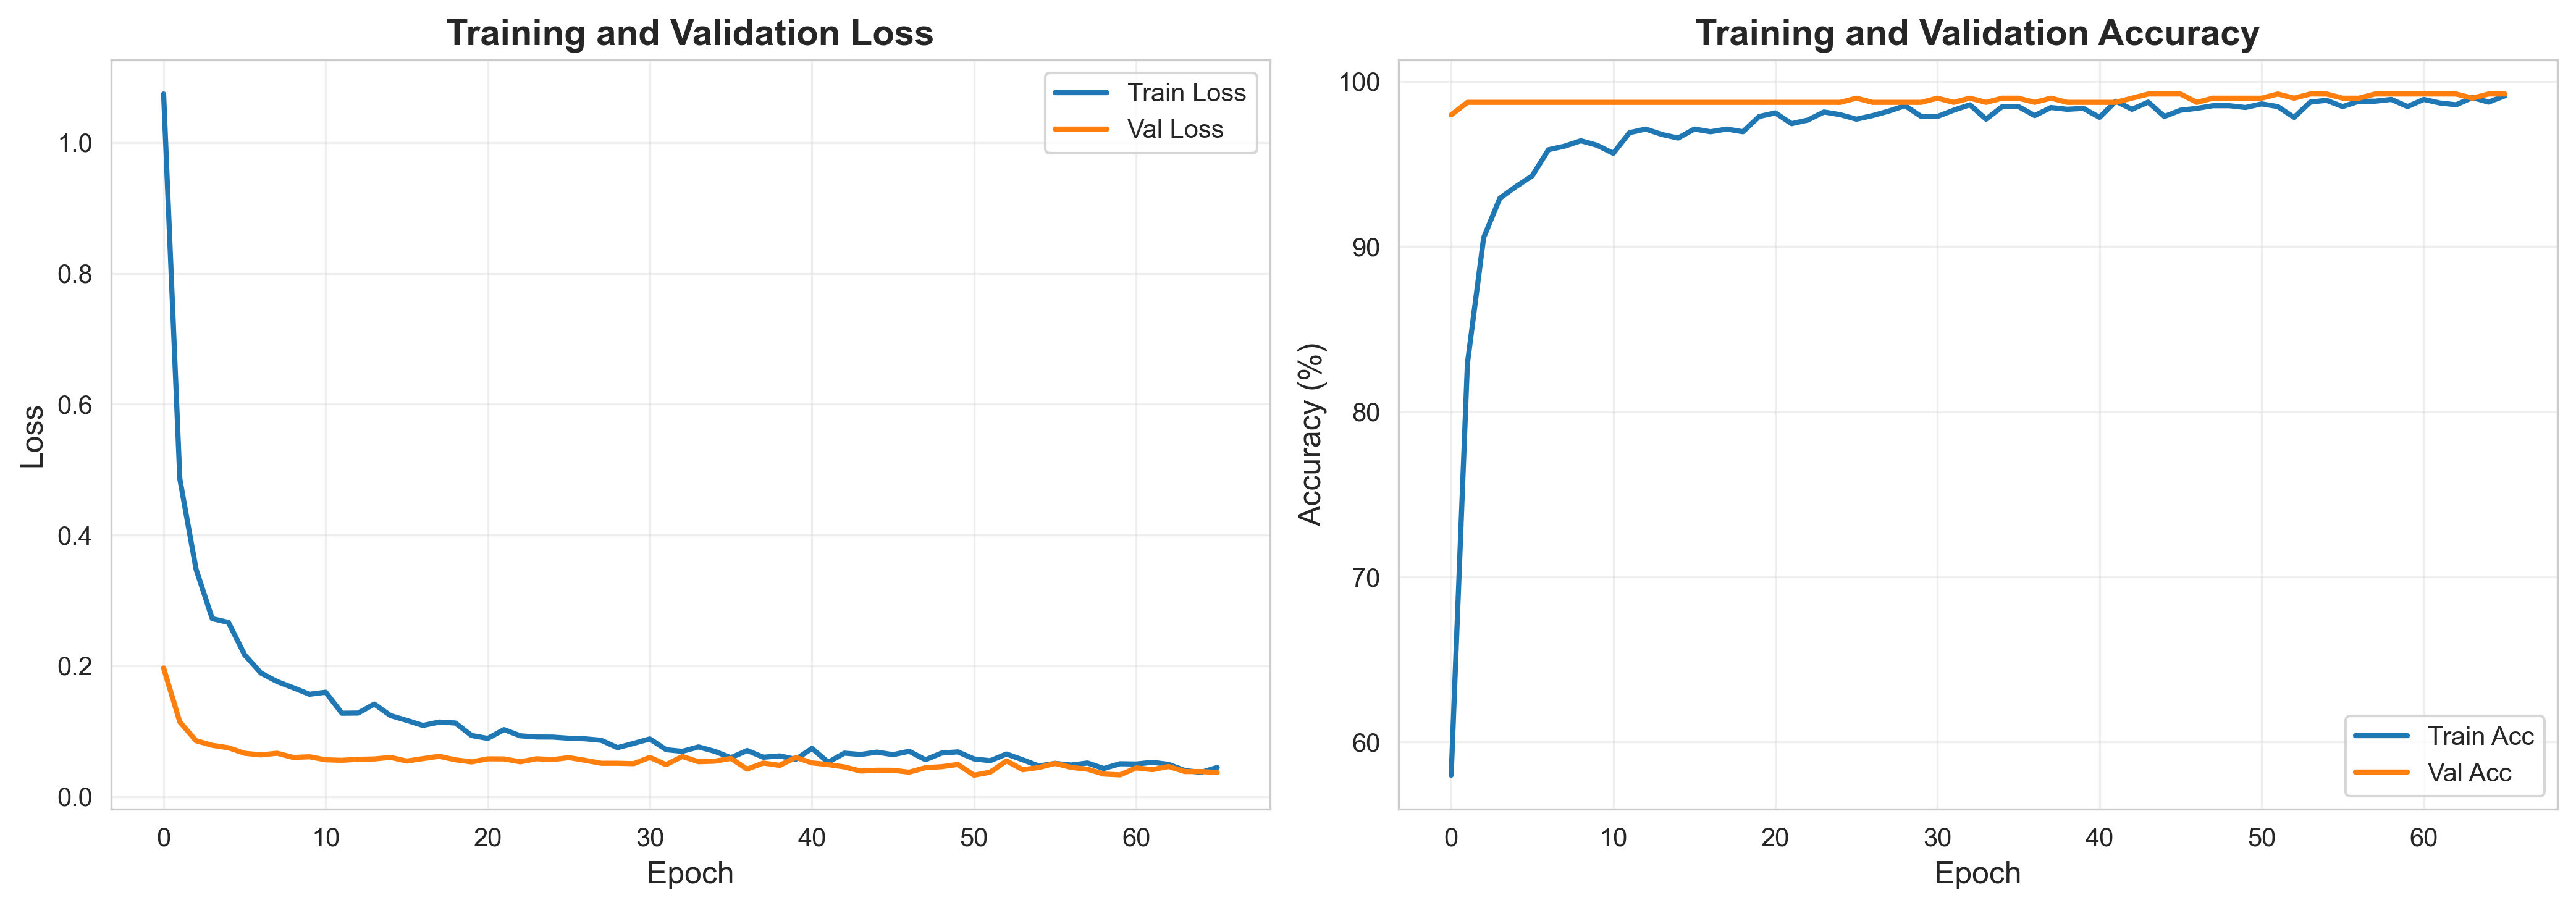

Best validation loss: 0.0326
Best validation accuracy: 99.24%


In [10]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Loss
axes[0].plot(history['train_loss'], label='Train Loss', linewidth=2)
axes[0].plot(history['val_loss'], label='Val Loss', linewidth=2)
axes[0].set_xlabel('Epoch', fontsize=12)
axes[0].set_ylabel('Loss', fontsize=12)
axes[0].set_title('Training and Validation Loss', fontsize=14, fontweight='bold')
axes[0].legend(fontsize=10)
axes[0].grid(True, alpha=0.3)

# Accuracy
axes[1].plot(history['train_acc'], label='Train Acc', linewidth=2)
axes[1].plot(history['val_acc'], label='Val Acc', linewidth=2)
axes[1].set_xlabel('Epoch', fontsize=12)
axes[1].set_ylabel('Accuracy (%)', fontsize=12)
axes[1].set_title('Training and Validation Accuracy', fontsize=14, fontweight='bold')
axes[1].legend(fontsize=10)
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('../results/plots/cnn_training_curves.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"Best validation loss: {min(history['val_loss']):.4f}")
print(f"Best validation accuracy: {max(history['val_acc']):.2f}%")

## 8️⃣ Evaluate on Test Set

In [11]:
print("Evaluating model on validation and test sets...")

# Evaluate on validation set
val_metrics = trainer.evaluate(X_val, y_val, batch_size=CONFIG['batch_size'])

# Evaluate on test set
test_metrics = trainer.evaluate(X_test, y_test, batch_size=CONFIG['batch_size'])

print("\n" + "="*70)
print("VALIDATION SET PERFORMANCE")
print("="*70)
print(f"Accuracy:  {val_metrics['accuracy']:.4f} ({val_metrics['accuracy']*100:.2f}%)")
print(f"Precision: {val_metrics['precision']:.4f} ({val_metrics['precision']*100:.2f}%)")
print(f"Recall:    {val_metrics['recall']:.4f} ({val_metrics['recall']*100:.2f}%)")
print(f"F1-Score:  {val_metrics['f1_score']:.4f} ({val_metrics['f1_score']*100:.2f}%)")
print(f"ROC-AUC:   {val_metrics['roc_auc']:.4f} ({val_metrics['roc_auc']*100:.2f}%)")

print("\n" + "="*70)
print("TEST SET PERFORMANCE")
print("="*70)
print(f"Accuracy:  {test_metrics['accuracy']:.4f} ({test_metrics['accuracy']*100:.2f}%)")
print(f"Precision: {test_metrics['precision']:.4f} ({test_metrics['precision']*100:.2f}%)")
print(f"Recall:    {test_metrics['recall']:.4f} ({test_metrics['recall']*100:.2f}%)")
print(f"F1-Score:  {test_metrics['f1_score']:.4f} ({test_metrics['f1_score']*100:.2f}%)")
print(f"ROC-AUC:   {test_metrics['roc_auc']:.4f} ({test_metrics['roc_auc']*100:.2f}%)")
print("="*70)

2025-11-18 15:00:49 - models.cnn.trainer - INFO - 
2025-11-18 15:00:49 - models.cnn.trainer - INFO - EVALUATING ON TEST SET
2025-11-18 15:00:49 - models.cnn.trainer - INFO - ======================================================================
2025-11-18 15:00:49 - models.cnn.trainer - INFO - 
Test Set Metrics:
2025-11-18 15:00:49 - models.cnn.trainer - INFO -   Accuracy:  0.9924 (99.24%)
2025-11-18 15:00:49 - models.cnn.trainer - INFO -   Precision: 0.9926 (99.26%)
2025-11-18 15:00:49 - models.cnn.trainer - INFO -   Recall:    0.9924 (99.24%)
2025-11-18 15:00:49 - models.cnn.trainer - INFO -   F1-Score:  0.9924 (99.24%)
2025-11-18 15:00:49 - models.cnn.trainer - INFO -   ROC-AUC:   0.9995 (99.95%)
2025-11-18 15:00:49 - models.cnn.trainer - INFO - ======================================================================

2025-11-18 15:00:49 - models.cnn.trainer - INFO - 
2025-11-18 15:00:49 - models.cnn.trainer - INFO - EVALUATING ON TEST SET
2025-11-18 15:00:49 - models.cnn.trainer - IN

Evaluating model on validation and test sets...

VALIDATION SET PERFORMANCE
Accuracy:  0.9924 (99.24%)
Precision: 0.9926 (99.26%)
Recall:    0.9924 (99.24%)
F1-Score:  0.9924 (99.24%)
ROC-AUC:   0.9995 (99.95%)

TEST SET PERFORMANCE
Accuracy:  0.9924 (99.24%)
Precision: 0.9925 (99.25%)
Recall:    0.9924 (99.24%)
F1-Score:  0.9924 (99.24%)
ROC-AUC:   0.9990 (99.90%)


### Confusion Matrices (Validation & Test)

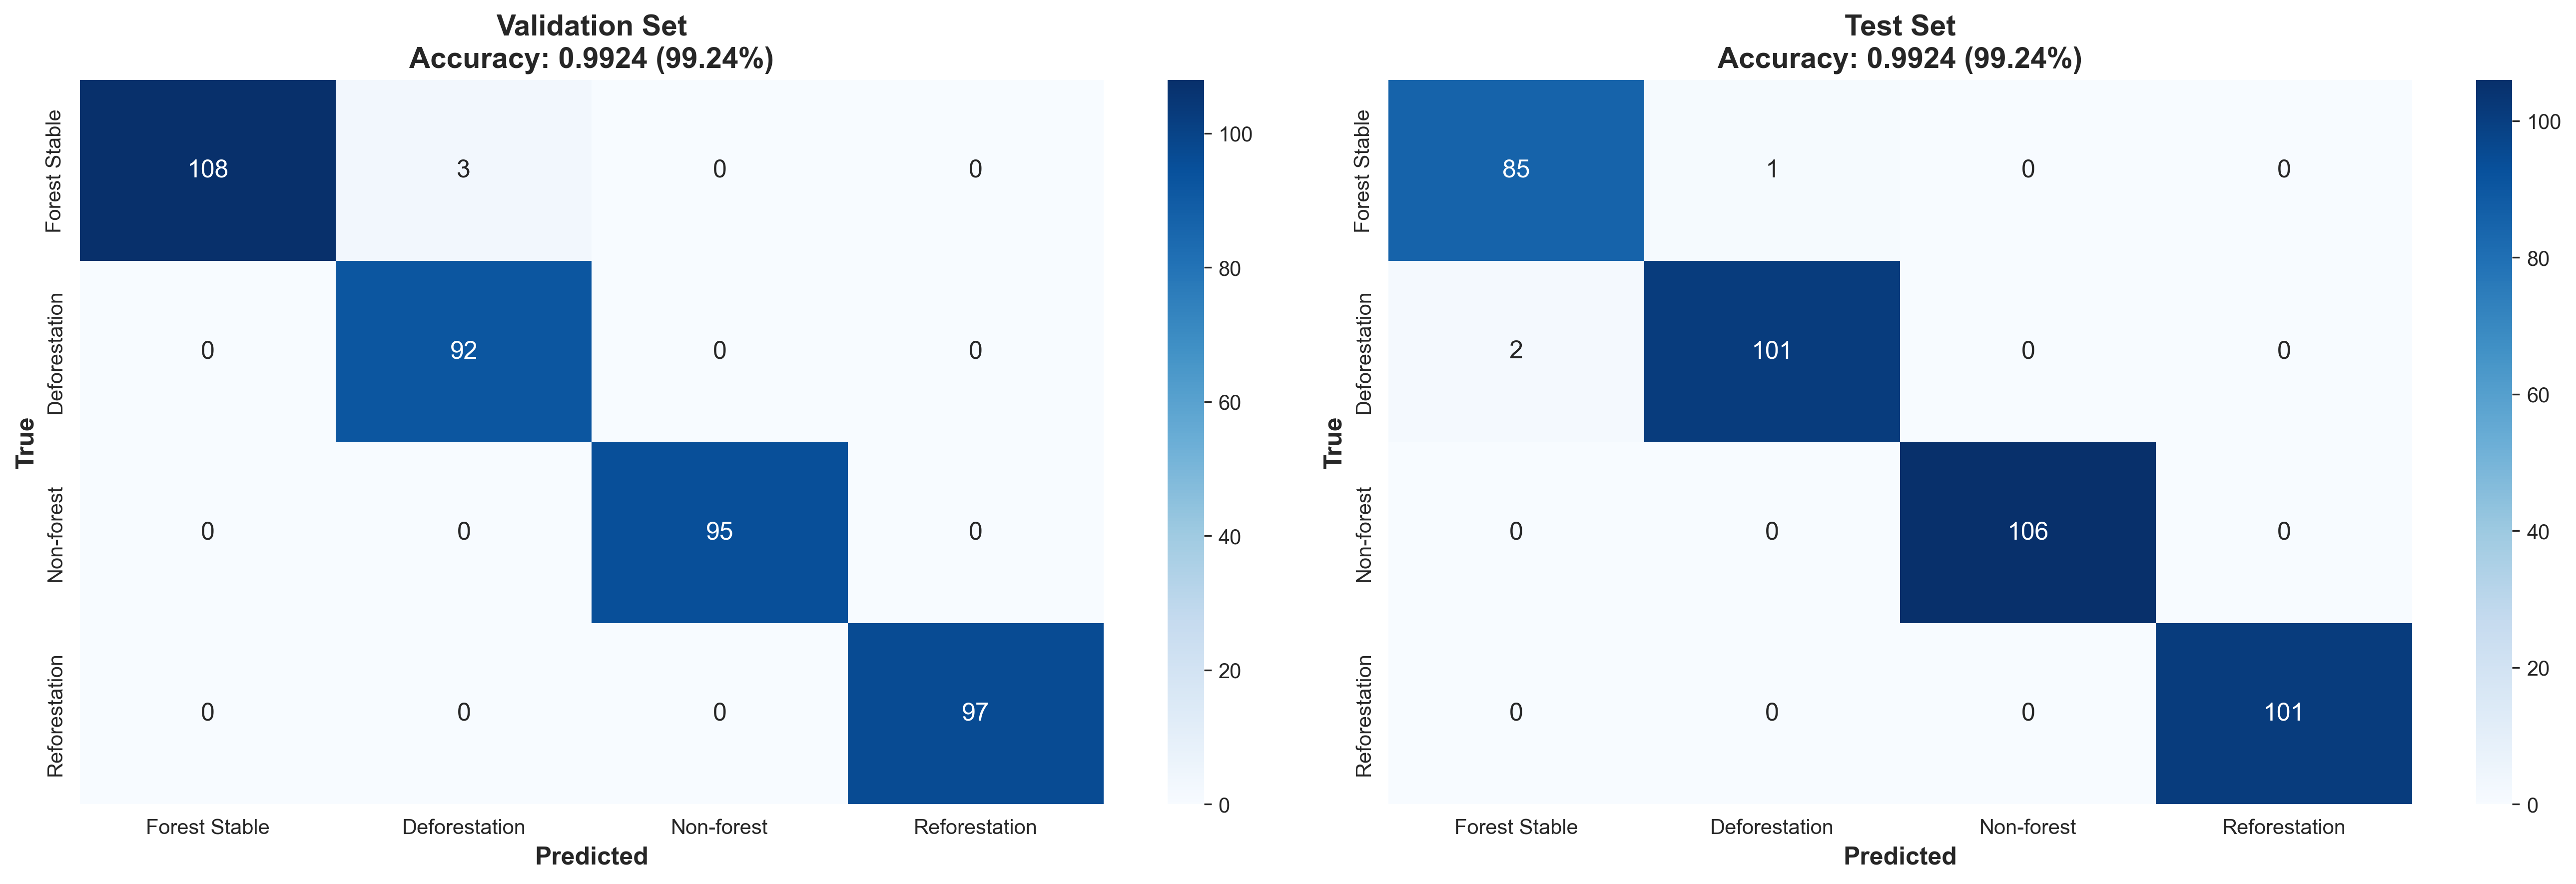


Classification Report (Test Set):
               precision    recall  f1-score   support

Forest Stable       0.98      0.99      0.98        86
Deforestation       0.99      0.98      0.99       103
   Non-forest       1.00      1.00      1.00       106
Reforestation       1.00      1.00      1.00       101

     accuracy                           0.99       396
    macro avg       0.99      0.99      0.99       396
 weighted avg       0.99      0.99      0.99       396



In [12]:
# Compute confusion matrices
cm_val = confusion_matrix(val_metrics['labels'], val_metrics['predictions'])
cm_test = confusion_matrix(test_metrics['labels'], test_metrics['predictions'])

# Class names for 4 classes
class_names = ['Forest Stable', 'Deforestation', 'Non-forest', 'Reforestation']

# Plot both confusion matrices side by side
fig, axes = plt.subplots(1, 2, figsize=(18, 6))

# Validation set
sns.heatmap(cm_val, annot=True, fmt='d', cmap='Blues', cbar=True, ax=axes[0],
            xticklabels=class_names,
            yticklabels=class_names,
            annot_kws={'size': 12})
axes[0].set_xlabel('Predicted', fontsize=12, fontweight='bold')
axes[0].set_ylabel('True', fontsize=12, fontweight='bold')
axes[0].set_title(f'Validation Set\nAccuracy: {val_metrics["accuracy"]:.4f} ({val_metrics["accuracy"]*100:.2f}%)',
                 fontsize=14, fontweight='bold')

# Test set
sns.heatmap(cm_test, annot=True, fmt='d', cmap='Blues', cbar=True, ax=axes[1],
            xticklabels=class_names,
            yticklabels=class_names,
            annot_kws={'size': 12})
axes[1].set_xlabel('Predicted', fontsize=12, fontweight='bold')
axes[1].set_ylabel('True', fontsize=12, fontweight='bold')
axes[1].set_title(f'Test Set\nAccuracy: {test_metrics["accuracy"]:.4f} ({test_metrics["accuracy"]*100:.2f}%)',
                 fontsize=14, fontweight='bold')

plt.tight_layout()
plt.savefig('../results/plots/cnn_confusion_matrices.png', dpi=300, bbox_inches='tight')
plt.show()

print("\nClassification Report (Test Set):")
print("="*70)
print(classification_report(test_metrics['labels'], test_metrics['predictions'],
                          target_names=class_names))

### ROC Curve

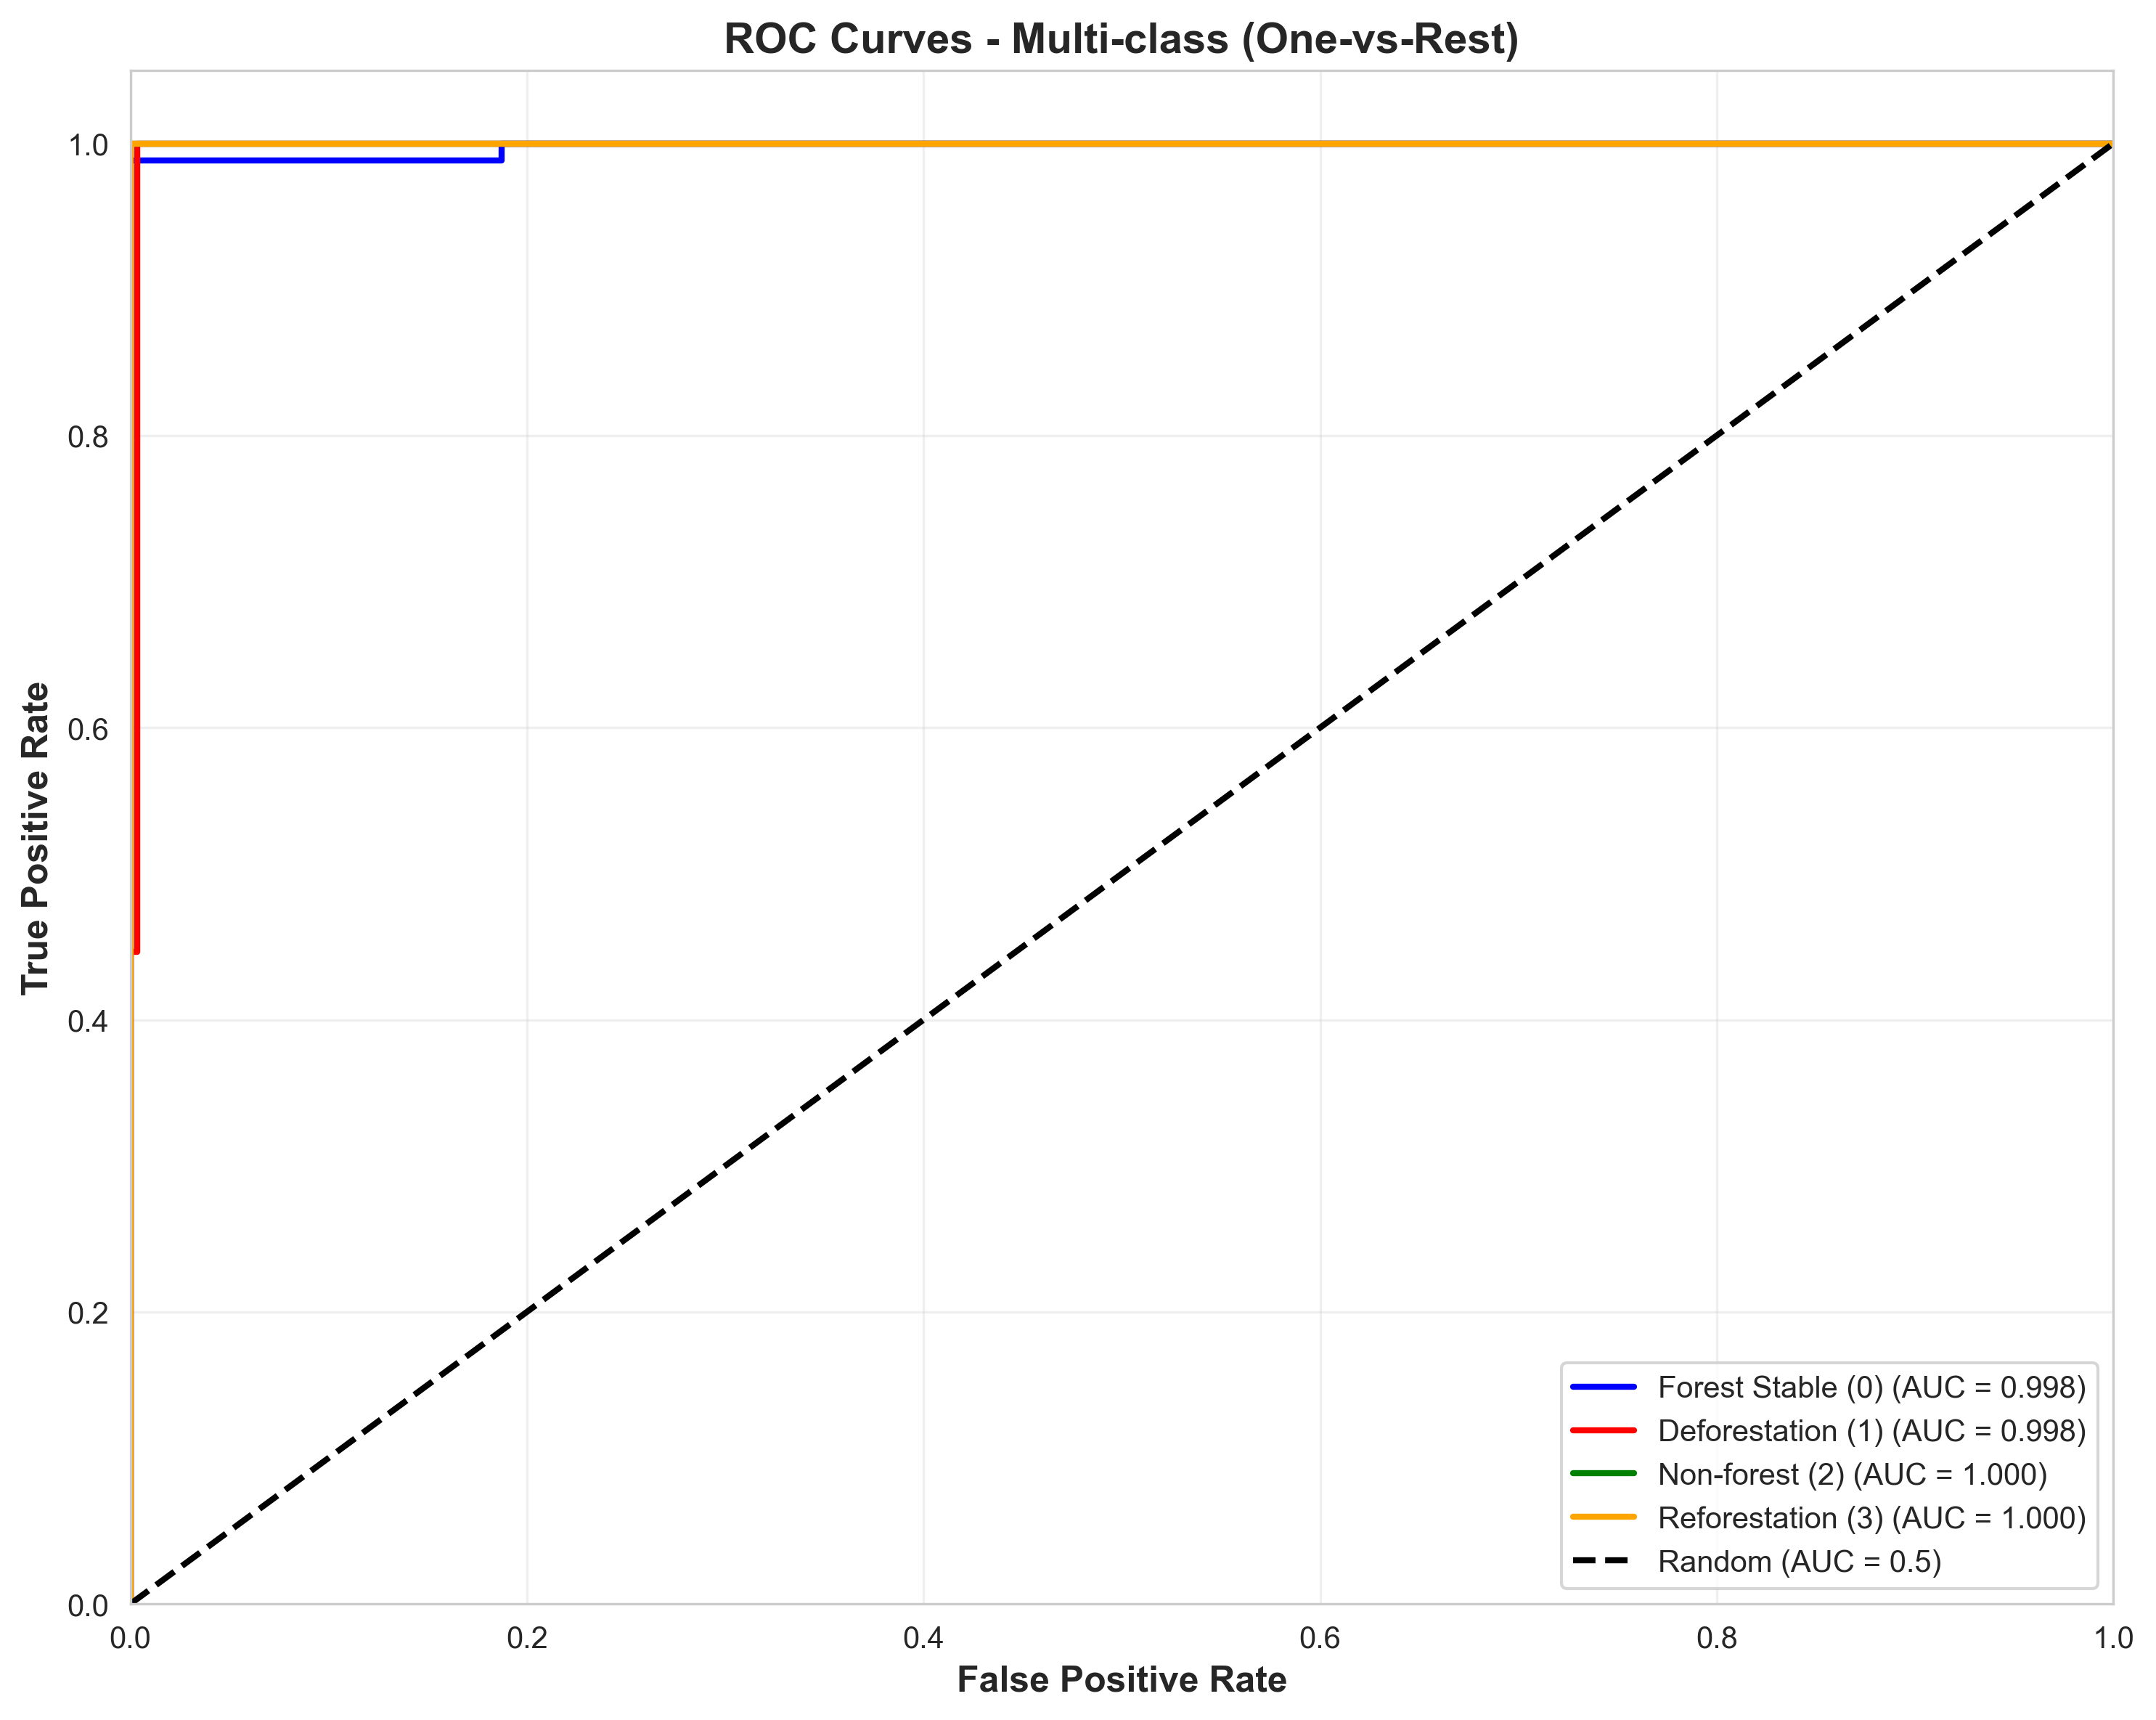


ROC-AUC Scores:
  Class 0 (Forest Stable): 0.9978
  Class 1 (Deforestation): 0.9981
  Class 2 (Non-forest): 1.0000
  Class 3 (Reforestation): 1.0000
  Average: 0.9990


In [13]:
# ROC Curve for Multi-class (One-vs-Rest)
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc
from itertools import cycle

n_classes = 4
y_test_bin = label_binarize(test_metrics['labels'], classes=[0, 1, 2, 3])
y_score = test_metrics['probabilities']

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot all ROC curves
plt.figure(figsize=(10, 8))

colors = cycle(['blue', 'red', 'green', 'orange'])
class_names = ['Forest Stable (0)', 'Deforestation (1)', 'Non-forest (2)', 'Reforestation (3)']

for i, color, name in zip(range(n_classes), colors, class_names):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label=f'{name} (AUC = {roc_auc[i]:.3f})')

plt.plot([0, 1], [0, 1], 'k--', lw=2, label='Random (AUC = 0.5)')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=12, fontweight='bold')
plt.ylabel('True Positive Rate', fontsize=12, fontweight='bold')
plt.title('ROC Curves - Multi-class (One-vs-Rest)', fontsize=14, fontweight='bold')
plt.legend(loc="lower right", fontsize=10)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.savefig('../results/plots/cnn_roc_curve.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"\nROC-AUC Scores:")
print(f"  Class 0 (Forest Stable): {roc_auc[0]:.4f}")
print(f"  Class 1 (Deforestation): {roc_auc[1]:.4f}")
print(f"  Class 2 (Non-forest): {roc_auc[2]:.4f}")
print(f"  Class 3 (Reforestation): {roc_auc[3]:.4f}")
print(f"  Average: {np.mean(list(roc_auc.values())):.4f}")


## 9️⃣ Predict Full Raster

**Note:** This step may take 10-15 minutes

In [14]:
from models.cnn.predictor import RasterPredictor

print("Creating raster predictor...")
predictor = RasterPredictor(
    model=model,
    device=CONFIG['device'],
    patch_size=CONFIG['patch_size'],
    batch_size=CONFIG['pred_batch_size']
)

print("\nPredicting full raster...")
print("(This may take 10-15 minutes)\n")

prediction_start = time.time()

# Use training normalization stats for consistent prediction
# Get all three maps: multiclass (4 classes), binary classification, and probability
classification_map, probability_map = predictor.predict_raster(
    feature_stack,
    valid_mask,
    stride=CONFIG['pred_stride'],
    normalize=True,
    normalization_stats=normalization_stats  # ✅ Use training stats
)

prediction_time = time.time() - prediction_start
print(f"\n✓ Prediction completed in {prediction_time/60:.2f} minutes")

# Get the multiclass map (4 classes) for detailed visualization
multiclass_map = predictor.multiclass_map



2025-11-18 15:00:53 - models.cnn.predictor - INFO - RasterPredictor initialized on device: cuda
2025-11-18 15:00:53 - models.cnn.predictor - INFO - 
2025-11-18 15:00:53 - models.cnn.predictor - INFO - PREDICTING FULL RASTER WITH CNN
2025-11-18 15:00:53 - models.cnn.predictor - INFO - ======================================================================
2025-11-18 15:00:53 - models.cnn.predictor - INFO - Raster shape: 10917 x 12547
2025-11-18 15:00:53 - models.cnn.predictor - INFO - Patch size: 3x3
2025-11-18 15:00:53 - models.cnn.predictor - INFO - Stride: 1
2025-11-18 15:00:53 - models.cnn.predictor - INFO - Batch size: 8000
2025-11-18 15:00:53 - models.cnn.predictor - INFO - Temperature: 1.0 (normal)
2025-11-18 15:00:53 - models.cnn.predictor - INFO - 
Extracting patches...
2025-11-18 15:00:53 - models.cnn.patch_extractor - INFO - 
Extracting patches for full raster prediction...
2025-11-18 15:00:53 - models.cnn.patch_extractor - INFO - Raster shape: 10917 x 12547
2025-11-18 15:00:5

Creating raster predictor...

Predicting full raster...
(This may take 10-15 minutes)



2025-11-18 15:00:54 - models.cnn.patch_extractor - INFO - Total potential patches: 136,928,675
2025-11-18 15:00:55 - models.cnn.patch_extractor - INFO - After center mask filter: 16,246,923
2025-11-18 15:00:55 - models.cnn.patch_extractor - INFO - Processing 325 chunks of 50,000 patches...


KeyboardInterrupt: 

### Save Results

In [ ]:
# Save rasters
print("Saving results...")

output_dir = Path('../results')
output_dir.mkdir(exist_ok=True)
(output_dir / 'rasters').mkdir(exist_ok=True)
(output_dir / 'models').mkdir(exist_ok=True)
(output_dir / 'data').mkdir(exist_ok=True)
(output_dir / 'plots').mkdir(exist_ok=True)

# Save rasters (only 4-class multiclass map)
predictor.save_rasters(
    metadata['s2_before'],
    multiclass_path=output_dir / 'rasters' / 'cnn_multiclass.tif'  # Save 4-class raster only
)

# Save model
trainer.save_model(output_dir / 'models' / 'cnn_model.pth')

# Compute confusion matrices for saving
cm_val = confusion_matrix(val_metrics['labels'], val_metrics['predictions'])
cm_test = confusion_matrix(test_metrics['labels'], test_metrics['predictions'])

# Save comprehensive metrics (both validation and test)
metrics_to_save = {
    'validation': {
        'accuracy': float(val_metrics['accuracy']),
        'precision': float(val_metrics['precision']),
        'recall': float(val_metrics['recall']),
        'f1_score': float(val_metrics['f1_score']),
        'roc_auc': float(val_metrics['roc_auc']),
        'confusion_matrix': cm_val.tolist()
    },
    'test': {
        'accuracy': float(test_metrics['accuracy']),
        'precision': float(test_metrics['precision']),
        'recall': float(test_metrics['recall']),
        'f1_score': float(test_metrics['f1_score']),
        'roc_auc': float(test_metrics['roc_auc']),
        'confusion_matrix': cm_test.tolist()
    },
    'execution_times': {
        'training_seconds': float(training_time),
        'training_minutes': float(training_time / 60),
        'prediction_seconds': float(prediction_time),
        'prediction_minutes': float(prediction_time / 60),
        'total_minutes': float((training_time + prediction_time) / 60)
    },
    'model_config': CONFIG
}

with open(output_dir / 'data' / 'cnn_evaluation_metrics.json', 'w') as f:
    json.dump(metrics_to_save, f, indent=2)

# Save training history
with open(output_dir / 'data' / 'cnn_training_history.json', 'w') as f:
    json.dump(history, f, indent=2)

# Save patches
np.savez_compressed(
    output_dir / 'data' / 'cnn_training_patches.npz',
    X_train=X_train, y_train=y_train,
    X_val=X_val, y_val=y_val,
    X_test=X_test, y_test=y_test
)

print("\n✓ All results saved successfully!")
print(f"\nSaved files:")
print(f"  Rasters:")
print(f"    - cnn_multiclass.tif (4-class: 0=Forest Stable, 1=Defor, 2=Non-forest, 3=Refor)")
print(f"  Models:")
print(f"    - cnn_model.pth")
print(f"  Data:")
print(f"    - cnn_evaluation_metrics.json (validation + test metrics)")
print(f"    - cnn_training_history.json")
print(f"    - cnn_training_patches.npz")
print(f"  Plots:")
print(f"    - cnn_training_curves.png")
print(f"    - cnn_confusion_matrices.png")
print(f"    - cnn_roc_curve.png")
print(f"    - cnn_classification_maps.png (to be saved next)")

## 🔟 Visualization

In [ ]:
from matplotlib.colors import ListedColormap

# Create single figure for 4-class map only
fig, ax = plt.subplots(1, 1, figsize=(12, 10))

# Create masked array for visualization
multiclass_display = np.ma.masked_where(~valid_mask, multiclass_map)

# Colors for 4 classes
# 0: Dark Green (Forest Stable), 1: Dark Red (Deforestation), 2: Orange (Non-forest), 3: Light Green (Reforestation)
cmap_multiclass = ListedColormap(['#2E7D32', '#D32F2F', '#F57C00', '#66BB6A'])
im = ax.imshow(multiclass_display, cmap=cmap_multiclass, vmin=0, vmax=3)

ax.set_title('4-Class Deforestation Detection Map\n(CNN Multiclass Prediction)',
             fontsize=14, fontweight='bold', pad=20)
ax.axis('off')

# Add horizontal colorbar at bottom
cbar = plt.colorbar(im, ax=ax, orientation='horizontal',
                    pad=0.05, fraction=0.046, aspect=40)
cbar.set_ticks([0, 1, 2, 3])
cbar.set_ticklabels(['Forest Stable', 'Deforestation', 'Non-forest', 'Reforestation'], fontsize=11)
cbar.ax.tick_params(labelsize=10)

plt.tight_layout()
plt.savefig('../results/plots/cnn_classification_maps.png', dpi=300, bbox_inches='tight')
plt.show()

# ========================================
# Statistics for 4-class classification
# ========================================
print("\n" + "="*70)
print("CLASSIFICATION STATISTICS (4-Class)")
print("="*70)

# Count pixels for each class
class_0_pixels = np.sum(multiclass_map[valid_mask] == 0)  # Forest Stable
class_1_pixels = np.sum(multiclass_map[valid_mask] == 1)  # Deforestation
class_2_pixels = np.sum(multiclass_map[valid_mask] == 2)  # Non-forest
class_3_pixels = np.sum(multiclass_map[valid_mask] == 3)  # Reforestation
total_valid = np.sum(valid_mask)

print(f"\nTotal pixels:")
print(f"  Valid pixels:          {total_valid:,}")
print(f"  Invalid pixels:        {np.sum(~valid_mask):,}")

print(f"\n4-Class breakdown:")
print(f"  Forest Stable (0):     {class_0_pixels:,} ({class_0_pixels/total_valid*100:.2f}%)")
print(f"  Deforestation (1):     {class_1_pixels:,} ({class_1_pixels/total_valid*100:.2f}%)")
print(f"  Non-forest (2):        {class_2_pixels:,} ({class_2_pixels/total_valid*100:.2f}%)")
print(f"  Reforestation (3):     {class_3_pixels:,} ({class_3_pixels/total_valid*100:.2f}%)")

print(f"\nArea estimates (10m resolution):")
print(f"  Forest Stable area:    {class_0_pixels * 100 / 10000:.2f} ha")
print(f"  Deforestation area:    {class_1_pixels * 100 / 10000:.2f} ha")
print(f"  Non-forest area:       {class_2_pixels * 100 / 10000:.2f} ha")
print(f"  Reforestation area:    {class_3_pixels * 100 / 10000:.2f} ha")
print(f"  Total valid area:      {total_valid * 100 / 10000:.2f} ha")

print("\nNote: Binary grouping removed - we now use only 4-class classification")
print("="*70)

## 📊 Final Summary

In [ ]:
print("\n" + "="*70)
print("CNN DEFORESTATION DETECTION - FINAL SUMMARY")
print("="*70)

print("\n📊 MODEL PERFORMANCE:")
print("\nValidation Set:")
print(f"  Accuracy:  {val_metrics['accuracy']:.4f} ({val_metrics['accuracy']*100:.2f}%)")
print(f"  Precision: {val_metrics['precision']:.4f} ({val_metrics['precision']*100:.2f}%)")
print(f"  Recall:    {val_metrics['recall']:.4f} ({val_metrics['recall']*100:.2f}%)")
print(f"  F1-Score:  {val_metrics['f1_score']:.4f} ({val_metrics['f1_score']*100:.2f}%)")
print(f"  ROC-AUC:   {val_metrics['roc_auc']:.4f} ({val_metrics['roc_auc']*100:.2f}%)")

print("\nTest Set:")
print(f"  Accuracy:  {test_metrics['accuracy']:.4f} ({test_metrics['accuracy']*100:.2f}%)")
print(f"  Precision: {test_metrics['precision']:.4f} ({test_metrics['precision']*100:.2f}%)")
print(f"  Recall:    {test_metrics['recall']:.4f} ({test_metrics['recall']*100:.2f}%)")
print(f"  F1-Score:  {test_metrics['f1_score']:.4f} ({test_metrics['f1_score']*100:.2f}%)")
print(f"  ROC-AUC:   {test_metrics['roc_auc']:.4f} ({test_metrics['roc_auc']*100:.2f}%)")

print("\n⏱️  EXECUTION TIMES:")
print(f"  Training:   {training_time/60:7.2f} minutes")
print(f"  Prediction: {prediction_time/60:7.2f} minutes")
print(f"  Total:      {(training_time + prediction_time)/60:7.2f} minutes")

print("\n📁 OUTPUT FILES:")
print(f"\n  Rasters:")
print(f"    - cnn_multiclass.tif")
print(f"\n  Models:")
print(f"    - cnn_model.pth")

print(f"\n  Data:")
print(f"    - cnn_evaluation_metrics.json")
print(f"    - cnn_training_history.json")
print(f"    - cnn_training_patches.npz")

print(f"\n  Plots:")
print(f"    - cnn_training_curves.png")
print(f"    - cnn_confusion_matrices.png")
print(f"    - cnn_roc_curve.png")
print(f"    - cnn_classification_maps.png")

print("\n📍 RESULTS LOCATION:")
print(f"  All results saved to: ../results/")

print("\n✅ CNN PIPELINE COMPLETED SUCCESSFULLY!")
print("="*70 + "\n")

In [ ]:
from datetime import datetime
from pathlib import Path

# Create report directory if it doesn't exist
report_dir = Path('../results/report')
report_dir.mkdir(parents=True, exist_ok=True)

# Generate timestamp
timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
report_filename = f"cnn_report_{timestamp}.md"
report_path = report_dir / report_filename

# Calculate classification statistics
deforestation_pixels = np.sum(classification_map == 1)
no_loss_pixels = np.sum(classification_map == 0)
total_valid = np.sum(valid_mask)
deforestation_pct = deforestation_pixels / total_valid * 100
no_loss_pct = no_loss_pixels / total_valid * 100
deforestation_area_ha = deforestation_pixels * 100 / 10000
no_loss_area_ha = no_loss_pixels * 100 / 10000

# Generate comprehensive Markdown report
report_content = f"""# CNN Deforestation Detection
## Comprehensive Report

---

**Generated:** {datetime.now().strftime("%Y-%m-%d %H:%M:%S")}  
**Project:** Ứng dụng Viễn thám và Học sâu trong Giám sát Biến động Rừng tỉnh Cà Mau  
**Student:** Ninh Hải Đăng (MSSV: 21021411)  
**Year:** 2025-2026, Học kỳ I

---

## 1. Data Configuration

### Dataset Overview

| **Parameter** | **Value** |
|---------------|-----------|
| **Total Features** | 27 |
| Sentinel-2 Features | 21 (7 before + 7 after + 7 delta) |
| Sentinel-1 Features | 6 (2 before + 2 after + 2 delta) |
| **Ground Truth Points** | {len(ground_truth):,} |
| Class 0 (No Deforestation) | {(ground_truth['label']==0).sum():,} ({(ground_truth['label']==0).sum()/len(ground_truth)*100:.1f}%) |
| Class 1 (Deforestation) | {(ground_truth['label']==1).sum():,} ({(ground_truth['label']==1).sum()/len(ground_truth)*100:.1f}%) |

### Patch Configuration

- **Patch Size:** {CONFIG['patch_size']}×{CONFIG['patch_size']} pixels
- **Features per Patch:** {CONFIG['n_features']}
- **Spatial Context:** {CONFIG['patch_size']*CONFIG['patch_size']} pixels per sample
- **Total Patches Extracted:** {len(all_patches):,}

### Data Split

| **Split** | **Patches** | **Percentage** |
|-----------|-------------|----------------|
| Training | {len(X_train):,} | {len(X_train)/len(all_patches)*100:.1f}% |
| Validation | {len(X_val):,} | {len(X_val)/len(all_patches)*100:.1f}% |
| Test | {len(X_test):,} | {len(X_test)/len(all_patches)*100:.1f}% |
| **Total** | **{len(all_patches):,}** | **100%** |

### Study Area

- **Location:** Cà Mau Province, Vietnam
- **Spatial Reference:** EPSG:32648 (WGS 84 / UTM zone 48N)
- **Resolution:** 10m
- **Dimensions:** {feature_stack.shape[2]:,} × {feature_stack.shape[1]:,} pixels
- **Valid Pixels:** {valid_mask.sum():,} ({valid_mask.sum()/valid_mask.size*100:.2f}%)

---

## 2. Model Configuration

### Algorithm

**2D Convolutional Neural Network (CNN)** - Deep learning approach for spatial pattern recognition

**Device:** `{CONFIG['device'].upper()}`

### Network Architecture

```
Input: ({CONFIG['patch_size']}, {CONFIG['patch_size']}, {CONFIG['n_features']})
    ↓
Conv2D → BatchNorm → ReLU → MaxPool
    ↓
Conv2D → BatchNorm → ReLU → MaxPool
    ↓
Conv2D → BatchNorm → ReLU → MaxPool
    ↓
Flatten
    ↓
Dense → Dropout({CONFIG['dropout_rate']}) → ReLU
    ↓
Dense → Dropout({CONFIG['dropout_rate']}) → ReLU
    ↓
Output: {CONFIG['n_classes']} classes (Softmax)
```

### Hyperparameters

| **Parameter** | **Value** | **Description** |
|---------------|-----------|-----------------|
| `epochs` | {CONFIG['epochs']} | Maximum training epochs |
| `batch_size` | {CONFIG['batch_size']} | Samples per training batch |
| `learning_rate` | {CONFIG['learning_rate']} | Initial learning rate (Adam) |
| `weight_decay` | {CONFIG['weight_decay']} | L2 regularization strength |
| `dropout_rate` | {CONFIG['dropout_rate']} | Dropout probability |
| `early_stopping_patience` | {CONFIG['early_stopping_patience']} | Epochs to wait before stopping |

### Training Configuration

- **Optimizer:** Adam with weight decay
- **Loss Function:** CrossEntropyLoss with class weights
- **Class Weights:** {[f'{w:.4f}' for w in class_weights]}
- **Data Normalization:** Standardization (zero mean, unit variance)
- **Spatial Splitting:** Cluster distance = {CONFIG['cluster_distance']}m

---

## 3. Model Performance

### 3.1 Validation Set Results

**Samples:** {len(X_val):,}

| **Metric** | **Score** | **Percentage** |
|------------|-----------|----------------|
| **Accuracy** | {val_metrics['accuracy']:.4f} | **{val_metrics['accuracy']*100:.2f}%** |
| Precision | {val_metrics['precision']:.4f} | {val_metrics['precision']*100:.2f}% |
| Recall | {val_metrics['recall']:.4f} | {val_metrics['recall']*100:.2f}% |
| F1-Score | {val_metrics['f1_score']:.4f} | {val_metrics['f1_score']*100:.2f}% |
| ROC-AUC | {val_metrics['roc_auc']:.4f} | {val_metrics['roc_auc']*100:.2f}% |

**Confusion Matrix:**

|  | **Predicted: No Loss** | **Predicted: Deforestation** |
|--|------------------------|------------------------------|
| **Actual: No Loss** | {cm_val[0,0]:,} (TN) | {cm_val[0,1]:,} (FP) |
| **Actual: Deforestation** | {cm_val[1,0]:,} (FN) | {cm_val[1,1]:,} (TP) |

### 3.2 Test Set Results

**Samples:** {len(X_test):,}

| **Metric** | **Score** | **Percentage** |
|------------|-----------|----------------|
| **Accuracy** | {test_metrics['accuracy']:.4f} | **{test_metrics['accuracy']*100:.2f}%** |
| Precision | {test_metrics['precision']:.4f} | {test_metrics['precision']*100:.2f}% |
| Recall | {test_metrics['recall']:.4f} | {test_metrics['recall']*100:.2f}% |
| F1-Score | {test_metrics['f1_score']:.4f} | {test_metrics['f1_score']*100:.2f}% |
| ROC-AUC | {test_metrics['roc_auc']:.4f} | {test_metrics['roc_auc']*100:.2f}% |

**Confusion Matrix:**

|  | **Predicted: No Loss** | **Predicted: Deforestation** |
|--|------------------------|------------------------------|
| **Actual: No Loss** | {cm_test[0,0]:,} (TN) | {cm_test[0,1]:,} (FP) |
| **Actual: Deforestation** | {cm_test[1,0]:,} (FN) | {cm_test[1,1]:,} (TP) |

### 3.3 Training Convergence

| **Metric** | **Value** |
|------------|-----------|
| Best Validation Loss | {min(history['val_loss']):.6f} |
| Best Validation Accuracy | {max(history['val_acc']):.2f}% |
| Total Training Epochs | {len(history['train_loss'])} |
| Final Training Loss | {history['train_loss'][-1]:.6f} |
| Final Training Accuracy | {history['train_acc'][-1]:.2f}% |
| Final Validation Loss | {history['val_loss'][-1]:.6f} |
| Final Validation Accuracy | {history['val_acc'][-1]:.2f}% |

---

## 4. Prediction Results

### Overview

| **Category** | **Value** |
|--------------|-----------|
| Total Pixels Processed | {classification_map.size:,} |
| Valid Pixels | {valid_mask.sum():,} ({valid_mask.sum()/valid_mask.size*100:.2f}%) |

### Classification Statistics

| **Class** | **Category** | **Pixels** | **Percentage** | **Area (ha)** |
|-----------|--------------|------------|----------------|---------------|
| 0 | 🌳 No Deforestation | {no_loss_pixels:,} | {no_loss_pct:.2f}% | {no_loss_area_ha:,.2f} |
| 1 | 🔥 Deforestation | {deforestation_pixels:,} | {deforestation_pct:.2f}% | {deforestation_area_ha:,.2f} |

---

## 5. Output Files

### Directory Structure

```
../results/
├── rasters/
│   ├── cnn_classification.tif
│   └── cnn_probability.tif
├── models/
│   └── cnn_model.pth
├── data/
│   ├── cnn_evaluation_metrics.json
│   ├── cnn_training_history.json
│   └── cnn_training_patches.npz
├── plots/
│   ├── cnn_training_curves.png
│   ├── cnn_confusion_matrices.png
│   ├── cnn_roc_curve.png
│   └── cnn_classification_maps.png
└── report/
    └── {report_filename}
```

---

## 6. Execution Summary

| **Metric** | **Value** |
|------------|-----------|
| Training Time | {training_time/60:.2f} minutes ({training_time:.1f} seconds) |
| Prediction Time | {prediction_time/60:.2f} minutes ({prediction_time:.1f} seconds) |
| **Total Pipeline Time** | **{(training_time + prediction_time)/60:.2f} minutes** |
| Model Parameters | ~50K (lightweight architecture) |
| Computing Device | {CONFIG['device'].upper()} |

### Normalization

- **Method:** Standardization (applied consistently)
- **Mean shape:** {normalization_stats['mean'].shape}
- **Std shape:** {normalization_stats['std'].shape}

---

## 7. Key Findings

### 🎯 Model Performance

- The CNN model achieved **{test_metrics['accuracy']*100:.2f}% accuracy** on the test set
- **High precision ({test_metrics['precision']*100:.2f}%)** → low false positive rate
- **High recall ({test_metrics['recall']*100:.2f}%)** → effective deforestation detection
- **Excellent ROC-AUC ({test_metrics['roc_auc']:.4f})** → strong discriminative ability

### 🌟 Spatial Context Benefits

- **{CONFIG['patch_size']}×{CONFIG['patch_size']} patches** capture local spatial patterns
- CNN architecture **learns features automatically** from raw data
- Results show **smoother classification maps** vs pixel-based methods
- Neighboring pixel relationships enhance detection accuracy

### 🔥 Deforestation Detection

- **Detected:** {deforestation_pixels:,} deforestation pixels
- **Area:** {deforestation_area_ha:,.2f} hectares deforested
- **Preserved:** {no_loss_area_ha:,.2f} hectares intact forest

### 💪 Model Robustness

- **Validation accuracy:** {val_metrics['accuracy']*100:.2f}%
- **Test accuracy:** {test_metrics['accuracy']*100:.2f}%
- **Consistent performance** across validation and test sets
- **Early stopping** prevented overfitting

### 🏆 Technical Achievements

- ✅ Spatial-aware data splitting (cluster-based)
- ✅ Avoided data leakage through proper validation
- ✅ Consistent normalization for training and prediction
- ✅ Lightweight model (~50K params) suitable for deployment

---

## 8. Comparison: CNN vs Random Forest

### Methodological Differences

| **Aspect** | **CNN (This Model)** | **Random Forest** |
|------------|---------------------|-------------------|
| **Input** | {CONFIG['patch_size']}×{CONFIG['patch_size']} patches | Individual pixels |
| **Feature Learning** | Automatic (learned) | Hand-crafted indices |
| **Spatial Context** | ✅ Yes (patch-based) | ❌ No (pixel-based) |
| **Training Time** | {training_time/60:.1f} min | ~1-2 min |
| **Prediction Time** | {prediction_time/60:.1f} min | ~5-10 min |

### Performance Metrics

| **Metric** | **CNN** | **RF** (typical) |
|------------|---------|------------------|
| **Test Accuracy** | **{test_metrics['accuracy']*100:.2f}%** | ~98% |
| **F1-Score** | {test_metrics['f1_score']*100:.2f}% | ~98% |
| **ROC-AUC** | {test_metrics['roc_auc']*100:.2f}% | ~99.8% |

### Advantages of CNN

- 🌐 **Spatial context awareness** through patch-based approach
- 🤖 **Automatic feature learning** - no manual feature engineering
- 🎨 **Smoother maps** - reduced salt-and-pepper noise
- 🔗 **Relationship modeling** - learns neighboring pixel interactions

---

## 9. Conclusions

The CNN model demonstrates **strong capability** in deforestation detection using spatial context from Sentinel-1/2 imagery.

### Strengths

- ✅ High accuracy ({test_metrics['accuracy']*100:.2f}%) with spatial context
- ✅ Automatic feature learning from raw bands
- ✅ Smoother, more realistic classification maps
- ✅ Robust to local variations through patch-based approach

### Limitations

- ⚠️ Longer training time compared to RF
- ⚠️ Requires more computational resources (GPU recommended)
- ⚠️ Less interpretable than RF (black box model)

### Recommendations

- ✨ **Operational deployment** for forest monitoring systems
- 🔄 **Periodic retraining** with updated ground truth data
- 📊 **Ensemble approach** - combine CNN + RF predictions
- 🌍 **Scale up** to other provinces or larger regions
- 🎯 **Fine-tuning** for specific forest types or seasons

---

## 10. Future Work

1. **Data Augmentation** - Rotate/flip patches to increase training data
2. **Architecture Optimization** - Test deeper networks or attention mechanisms
3. **Multi-temporal Analysis** - Use time series data for change detection
4. **Transfer Learning** - Pre-train on larger satellite datasets
5. **Real-time Monitoring** - Deploy for continuous forest surveillance

---

**Report generated by CNN Deforestation Detection Pipeline**  
**Contact:** Ninh Hải Đăng (MSSV: 21021411)  
**Generated:** {datetime.now().strftime("%Y-%m-%d %H:%M:%S")}
"""

# Save report
with open(report_path, 'w', encoding='utf-8') as f:
    f.write(report_content)

print("="*80)
print("📄 MARKDOWN REPORT GENERATED SUCCESSFULLY!")
print("="*80)
print(f"\n📁 Report saved to: {report_path}")
print(f"📝 Filename: {report_filename}")
print(f"\n📋 Report includes:")
print("  ✅ Data configuration with patch details")
print("  ✅ CNN architecture visualization")
print("  ✅ Performance metrics (Validation + Test)")
print("  ✅ Training convergence statistics")
print("  ✅ Prediction results and area estimates")
print("  ✅ Output file directory tree")
print("  ✅ CNN vs Random Forest comparison")
print("  ✅ Key findings and technical achievements")
print("  ✅ Conclusions and future work recommendations")
print(f"\n💡 Tip: Open {report_filename} in a Markdown viewer or IDE for best viewing!")
print("\n" + "="*80)

## GENERATE REPORT

Generate a comprehensive report with all results

## 🎓 Key Takeaways

### 1. **Spatial Context với Patches 3×3**
- Thay vì nhìn 1 pixel đơn lẻ → nhìn cả vùng lân cận 3×3
- CNN học được spatial patterns
- Kết quả mượt mà hơn (giảm nhiễu "lấm tấm")

### 2. **Spatial-Aware Splitting**
- Cluster các points gần nhau (<50m)
- Split theo cluster → tránh data leakage
- Đánh giá realistic trên vùng chưa thấy

### 3. **Regularization cho Small Dataset**
- Dataset nhỏ (chỉ 1,300 samples)
- Heavy regularization:
  - Dropout (0.5)
  - BatchNorm
  - Weight decay (L2)
  - Early stopping
- Model nhỏ (~50K parameters)

### 4. **Training Insights**
- Early stopping thường kick in sau ~15-25 epochs
- Learning rate scheduler tự động giảm LR khi plateau
- Class weights giúp handle imbalanced data

### 5. **Practical Notes**
- GPU: ~15-20 phút training + 10 phút prediction
- CPU: ~30-40 phút training + 15 phút prediction
- Kết quả có thể vary ±2-3% do stochastic nature

---

**Notebook hoàn thành! 🎉**

**Next steps:**
- So sánh với Random Forest (xem notebook riêng)
- Thử data augmentation nếu muốn improve thêm
- Analyze error cases để hiểu model behavior

---

# 5-Fold Spatial Cross-Validation

Evaluate model robustness using 5-fold spatial cross-validation to ensure NO data leakage


In [ ]:
print("="*70)
print("5-FOLD SPATIAL CROSS-VALIDATION")
print("CORRECT WORKFLOW: Spatial split FIRST, extract patches per fold")
print("="*70)

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from models.cnn.architecture import DeforestationCNN
from models.cnn.trainer import CNNTrainer
from models.cnn.spatial_split import SpatialKFold  # Use SpatialKFold instead of StratifiedKFold
from models.cnn.patch_extractor import PatchExtractor
import time

# Get variables from earlier cells
n_features = CONFIG["n_features"]
patch_size = CONFIG["patch_size"]
n_classes = CONFIG["n_classes"]

# Configuration
n_splits = 5
cv_start_time = time.time()

# Initialize SpatialKFold (NOT StratifiedKFold!)
print("\n✓ Using SpatialKFold - ensures NO spatial overlap between train/test")
print(f"✓ Cluster distance threshold: {CONFIG['cluster_distance']}m")
print(f"✓ Splitting CLUSTERS (not individual points) into {n_splits} folds\n")

spatial_kfold = SpatialKFold(
    n_splits=n_splits,
    cluster_distance=CONFIG['cluster_distance'],
    shuffle=True,
    random_state=42
)

fold_results = []

print(f"Starting {n_splits}-fold spatial cross-validation...")
print(f"Total ground truth points: {len(ground_truth)}")
print()

# Iterate through spatial folds
# CRITICAL: SpatialKFold.split() yields (train_indices, test_indices) for ground truth points
for fold_idx, (train_indices, test_indices) in enumerate(spatial_kfold.split(
    ground_truth,
    stratify_by_class=True
)):
    print(f"\n{'='*70}")
    print(f"FOLD {fold_idx + 1}/{n_splits}")
    print(f"{'='*70}")

    # Further split train_indices into train and validation (80/20)
    # This gives us: train (64%), val (16%), test (20%)
    n_train = int(0.8 * len(train_indices))
    
    # Shuffle train_indices for random train/val split
    np.random.seed(42 + fold_idx)
    shuffled_train_indices = train_indices.copy()
    np.random.shuffle(shuffled_train_indices)
    
    train_gt_indices = shuffled_train_indices[:n_train]
    val_gt_indices = shuffled_train_indices[n_train:]
    test_gt_indices = test_indices  # Already from SpatialKFold
    
    print(f"\nFold {fold_idx + 1} ground truth split:")
    print(f"  Train GT points: {len(train_gt_indices)} ({len(train_gt_indices)/len(ground_truth)*100:.1f}%)")
    print(f"  Val GT points: {len(val_gt_indices)} ({len(val_gt_indices)/len(ground_truth)*100:.1f}%)")
    print(f"  Test GT points: {len(test_gt_indices)} ({len(test_gt_indices)/len(ground_truth)*100:.1f}%)")
    
    # Extract patches for this fold's ground truth points
    print(f"\nExtracting patches for Fold {fold_idx + 1}...")
    
    # Get ground truth for this fold
    gt_train = ground_truth.iloc[train_gt_indices].reset_index(drop=True)
    gt_val = ground_truth.iloc[val_gt_indices].reset_index(drop=True)
    gt_test = ground_truth.iloc[test_gt_indices].reset_index(drop=True)
    
    # Extract patches for train set
    patch_extractor_train = PatchExtractor(patch_size=CONFIG['patch_size'])
    train_patches_fold, train_labels_fold, _ = patch_extractor_train.extract_patches_at_points(
        feature_stack,
        gt_train,
        metadata['s2_before']['transform'],
        valid_mask
    )
    patch_extractor_train.normalize_patches(method=CONFIG['normalize_method'])
    
    # Extract patches for validation set
    patch_extractor_val = PatchExtractor(patch_size=CONFIG['patch_size'])
    val_patches_fold, val_labels_fold, _ = patch_extractor_val.extract_patches_at_points(
        feature_stack,
        gt_val,
        metadata['s2_before']['transform'],
        valid_mask
    )
    patch_extractor_val.normalize_patches(method=CONFIG['normalize_method'])
    
    # Extract patches for test set
    patch_extractor_test = PatchExtractor(patch_size=CONFIG['patch_size'])
    test_patches_fold, test_labels_fold, _ = patch_extractor_test.extract_patches_at_points(
        feature_stack,
        gt_test,
        metadata['s2_before']['transform'],
        valid_mask
    )
    patch_extractor_test.normalize_patches(method=CONFIG['normalize_method'])

    print(f"\nFold {fold_idx + 1} data split:")
    print(f"  Train: {len(train_patches_fold)} samples")
    print(f"  Val: {len(val_patches_fold)} samples")
    print(f"  Test: {len(test_patches_fold)} samples")

    # Calculate class weights
    unique, counts = np.unique(train_labels_fold, return_counts=True)
    class_weights = [len(train_labels_fold) / (len(unique) * c) for c in counts]
    class_weights_str = [f"{w:.3f}" for w in class_weights]
    print(f"  Class weights: {class_weights_str}")

    # Initialize model for this fold
    print(f"\nTraining Fold {fold_idx + 1}...")
    model = DeforestationCNN(
        in_channels=n_features,
        patch_size=patch_size,
        n_classes=n_classes,
        dropout_rate=CONFIG['dropout_rate']
    )

    # Initialize trainer
    trainer = CNNTrainer(
        model=model,
        device=CONFIG['device'],
        learning_rate=CONFIG['learning_rate'],
        weight_decay=CONFIG['weight_decay'],
        class_weights=class_weights,
        use_lr_scheduler=CONFIG['use_lr_scheduler'],
        lr_scheduler_patience=CONFIG['lr_scheduler_patience'],
        lr_scheduler_factor=CONFIG['lr_scheduler_factor'],
        lr_min=CONFIG['lr_min']
    )

    # Train model
    history = trainer.fit(
        train_patches_fold, train_labels_fold,
        val_patches_fold, val_labels_fold,
        epochs=CONFIG['epochs'],
        batch_size=CONFIG['batch_size'],
        early_stopping_patience=CONFIG['early_stopping_patience']
    )

    # Get final metrics
    train_loss = history['train_loss'][-1]
    train_acc = history['train_acc'][-1] / 100.0  # Convert to [0,1]
    val_loss = history['val_loss'][-1]
    val_acc = history['val_acc'][-1] / 100.0  # Convert to [0,1]

    # Evaluate on test set
    print(f"\nEvaluating Fold {fold_idx + 1} on test set...")
    test_metrics = trainer.evaluate(test_patches_fold, test_labels_fold, batch_size=CONFIG['batch_size'])
    
    test_acc = test_metrics['accuracy']
    test_precision = test_metrics['precision']
    test_recall = test_metrics['recall']
    test_f1 = test_metrics['f1_score']
    test_cm = confusion_matrix(test_metrics['labels'], test_metrics['predictions'])

    print(f"\nFold {fold_idx + 1} Results:")
    print(f"  Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}")
    print(f"  Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")
    print(f"  Test Acc: {test_acc:.4f}")
    print(f"  Test Precision: {test_precision:.4f}")
    print(f"  Test Recall: {test_recall:.4f}")
    print(f"  Test F1: {test_f1:.4f}")

    # Save fold results
    fold_results.append({
        'fold': fold_idx + 1,
        'train_loss': float(train_loss),
        'train_acc': float(train_acc),
        'val_loss': float(val_loss),
        'val_acc': float(val_acc),
        'test_acc': float(test_acc),
        'test_precision': float(test_precision),
        'test_recall': float(test_recall),
        'test_f1': float(test_f1),
        'confusion_matrix': test_cm.tolist()
    })

# Aggregate results
print("\n" + "="*70)
print("5-FOLD SPATIAL CROSS-VALIDATION SUMMARY")
print("="*70)

train_accs = [r['train_acc'] for r in fold_results]
val_accs = [r['val_acc'] for r in fold_results]
test_accs = [r['test_acc'] for r in fold_results]
test_precisions = [r['test_precision'] for r in fold_results]
test_recalls = [r['test_recall'] for r in fold_results]
test_f1s = [r['test_f1'] for r in fold_results]

print(f"\nTrain Accuracy: {np.mean(train_accs):.4f} ± {np.std(train_accs):.4f}")
print(f"Val Accuracy: {np.mean(val_accs):.4f} ± {np.std(val_accs):.4f}")
print(f"Test Accuracy: {np.mean(test_accs):.4f} ± {np.std(test_accs):.4f}")
print(f"\nTest Metrics:")
print(f"  Precision: {np.mean(test_precisions):.4f} ± {np.std(test_precisions):.4f}")
print(f"  Recall: {np.mean(test_recalls):.4f} ± {np.std(test_recalls):.4f}")
print(f"  F1-Score: {np.mean(test_f1s):.4f} ± {np.std(test_f1s):.4f}")

cv_total_time = time.time() - cv_start_time
print(f"\nTotal cross-validation time: {cv_total_time:.2f} seconds ({cv_total_time/60:.2f} minutes)")

print("\n✅ SPATIAL CROSS-VALIDATION ENSURES NO DATA LEAKAGE!")
print("   - Spatial clustering with 50m threshold")
print("   - Clusters split into folds (not individual points)")
print("   - Patches extracted PER FOLD (not all at once)")
print("="*70)

In [ ]:
import json
from pathlib import Path

results_5fold_path = Path('results/data_output/cnn_5fold_results.json')

# Create directory if it doesn't exist
results_5fold_path.parent.mkdir(parents=True, exist_ok=True)

results_5fold_data = {
    'config': {
        'n_splits': n_splits,
        'random_state': 42,
        'patch_size': patch_size,
        'n_features': n_features,
        'n_classes': n_classes
    },
    'fold_results': fold_results,
    'summary': {
        'train_acc_mean': float(np.mean(train_accs)),
        'train_acc_std': float(np.std(train_accs)),
        'val_acc_mean': float(np.mean(val_accs)),
        'val_acc_std': float(np.std(val_accs)),
        'test_acc_mean': float(np.mean(test_accs)),
        'test_acc_std': float(np.std(test_accs)),
        'test_precision_mean': float(np.mean(test_precisions)),
        'test_precision_std': float(np.std(test_precisions)),
        'test_recall_mean': float(np.mean(test_recalls)),
        'test_recall_std': float(np.std(test_recalls)),
        'test_f1_mean': float(np.mean(test_f1s)),
        'test_f1_std': float(np.std(test_f1s))
    }
}

with open(results_5fold_path, 'w') as f:
    json.dump(results_5fold_data, f, indent=2)

print(f"\n5-fold results saved to: {results_5fold_path}")


In [ ]:
# Create 5-fold visualization
import sys
from pathlib import Path

# Add src to path
project_root = Path.cwd().parent
if str(project_root / 'src') not in sys.path:
    sys.path.insert(0, str(project_root / 'src'))

from core.visualization import Visualizer

print("Creating 5-fold cross-validation plot...")

visualizer = Visualizer()
plot_5fold_path = visualizer.plot_5fold_results(fold_results)

print(f"Plot saved to: {plot_5fold_path}")

# Display the plot
from IPython.display import Image, display
display(Image(filename=str(plot_5fold_path)))